In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [121]:
# get data from files
courtdata = pd.read_csv('courtdata.csv', sep=',', encoding='latin-1')
neighborhood_income = pd.read_csv("American_Community_Survey_2013_-_17_Estimates_by_Neighborhood__Median_Income.csv")
building_permits = pd.read_csv("Housing_Starts_Map.csv")
addresses = pd.read_csv("Master_Addresses_List.csv")

In [122]:
# preview data
print(courtdata.columns)
print(neighborhood_income.columns)
print(building_permits.columns)
print(addresses.columns)

Index(['Case Number', 'Status', 'FIle Date', 'Plaintiff', 'P-Attorney',
       'Deffendant', 'D-Attorney', 'Property Address', 'Docket',
       'Judgement Date', 'Judgement Type', 'JudgeMent Method',
       'Judgement Total', 'Execution Total'],
      dtype='object')
Index(['Neighborhood ', 'Area', 'Median Household Income',
       'Median Family Income', 'Latitude', 'Longitude',
       'Neighborhood Centerpoint'],
      dtype='object')
Index(['ID', 'Application Address', 'Geocode Address', 'Map-Lot',
       'Neighborhood', 'Year Permitted', 'Fiscal Year Permitted', 'Prior Use',
       'Permitted Use', 'Housing Starts', 'Net Change in Units', 'Location'],
      dtype='object')
Index(['Address ID', 'Full Address', 'Street Number', 'Street Name',
       'Building ID', 'MapLot', 'Latitude', 'Longitude', 'Type', 'Zip Code',
       'Neighborhood', 'Election Ward', 'Election Precinct',
       'Election Polling Address', 'Representation District',
       'Senate District', 'CAD Reporting Dist

In [123]:
# deliverable 1 code
data_val = courtdata.values

plaintiff = data_val[:,3]
attorney = data_val[:,6]
judgment = data_val[:,10]
appear = data_val[:,11]
money = data_val[:,12]

#print(attorney)
#print(judgment)

nan = np.nan

total_cases = len(attorney)

plaintiff_data = np.zeros((total_cases,1))
attorney_data = np.zeros((total_cases,1))
judgment_data = np.zeros((total_cases,1))
appear_data = np.zeros((total_cases,1))
money_data = np.zeros((total_cases,1))

for i in range(total_cases):
    if isinstance(attorney[i], str):
        attorney_data[i] = 0 # with representation
    else:
        attorney_data[i] = 1 # no representation
    if judgment[i] == 'Judgment for Plaintiff for Possession and Rent':
        judgment_data[i] = 1 # conviction 
    else:
        judgment_data[i] = 0 # no conviction
    if appear[i] == 'after defendant(s) failed to appear':
        appear_data[i] = 0 # no show
    else: 
        appear_data[i] = 1 # showed up
    if isinstance(money[i], str):
        money[i] = money[i].replace(',','')
    if isinstance(money[i], float):
        money_data[i] = 0 # no money due
    else:
        money_data[i] = float(money[i]) # money due
    if plaintiff[i] == 'Cambridge Housing Authority':
        plaintiff_data[i] = 1 # cambridge housing authority 
    else:
        plaintiff_data[i] = 0 # other
        
data_total = np.hstack((plaintiff_data,attorney_data,judgment_data,appear_data,money_data))
#print(data_total) 
  
total = data_total/data_total.max(axis=0)
#print(total) 

# USE THIS FOR DELIVERABLE 1
total_pd = pd.DataFrame(total, columns=['plaintiff', 'attorney', 'judgement', 'appeared', 'payment'])



In [124]:
# add address data
total_pd['address'] = courtdata['Property Address']

def transform_address(addr):
    """transform address from court data into the form used by the 
       master address list
    """
    result = None
    for i in range(len(addr)):
        if addr[i] == '#' or addr[i:i+5] == 'Unit' or addr[i:i+3] == 'Apt':
            result = addr[:i-1]
            break
    if not result:
        return
    if result[-6:] == 'Street':
        result = result[:-7] + ' St'
    elif result[-6:] == 'Avenue':
        result = result[:-7] + " Ave"
    elif result[-5:] == 'Court':
        result = result[:-6] + ' Ct'
    elif result[-5:] == 'Place':
        result = result[:-6] + ' Pl'
    elif result[-5:] == 'Drive':
        result = result[:-6] + ' Dr'
    elif result[-4:] == 'Road':
        result = result[:-5] + ' Rd'
    elif result[-7:] == 'Gardens':
        result = result[:-8] + ' Gdns'
    else:
        result = None
    return result

total_pd = total_pd.assign(address=lambda df: df.address.apply(transform_address))

In [125]:
#drop rows with addresses that are not in the general format (apt. number is prepended with #)
total_pd = total_pd.dropna()

In [126]:
# get geospatial coordinates
def getCoords(addr):
    lat = None
    long = None
    matches = addresses[addresses['Full Address'] == addr]
    if not len(matches) == 0:
        lat = matches.Latitude.iloc[0]
        long = matches.Longitude.iloc[0]
    return lat, long

def getNeighborhood(addr):
    neighborhood = None
    matches = addresses[addresses['Full Address'] == addr]
    if not len(matches) == 0:
        neighborhood = matches.Neighborhood.iloc[0]
    return neighborhood

In [127]:
total_pd = total_pd.assign(coords=lambda df: df.address.apply(getCoords))
total_pd = total_pd.assign(neighborhood=lambda df: df.address.apply(getNeighborhood))

In [139]:
# look at some basic stats about neighborhood

# for each neighborhood the first element is the number evicted and the second is the number not evicted
freqs = {}

def getfreq(loc):
    x = len(total_pd[total_pd['neighborhood'] == loc][total_pd.judgement == 1.0])
    y = len(total_pd[total_pd['neighborhood'] == loc][total_pd.judgement == 0.0])
    freqs.update({loc: (x, y)})

for loc in neighborhood_income['Neighborhood ']:
    getfreq(loc)

<ipython-input-139-1391dda110c1>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = len(total_pd[total_pd['neighborhood'] == loc][total_pd.judgement == 1.0])
<ipython-input-139-1391dda110c1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = len(total_pd[total_pd['neighborhood'] == loc][total_pd.judgement == 0.0])


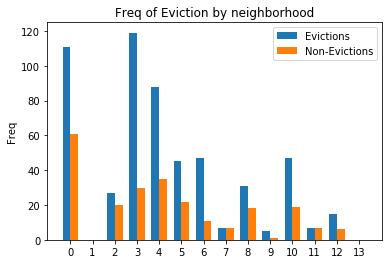

x axis labels:
East Cambridge: 0
MIT: 1
Wellington-Harrington: 2
The Port: 3
Cambridgeport: 4
Mid-Cambridge: 5
Riverside: 6
Agassiz: 7
Neighborhood Nine: 8
West Cambridge: 9
North Cambridge: 10
Cambridge Highlands: 11
Strawberry Hill: 12
City of Cambridge: 13


In [160]:
#show difference in frequencies of evictions
width = 0.35
ind = np.arange(len(freqs))

evictions = [freqs[x][0] for x in freqs]
non_evictions = [freqs[x][1] for x in freqs]

plt.bar(ind, evictions, width, label='Evictions')
plt.bar(ind+width, non_evictions, width, label='Non-Evictions')

plt.ylabel('Freq')
plt.title('Freq of Eviction by neighborhood')
plt.legend(loc='best')

plt.xticks(ind + width / 2, range(len(freqs)))

plt.show()

print('x axis labels:')
count = 0
for x in freqs:
    print(x + ":", count)
    count += 1

In [163]:
print('Ratio of Eviction judgements to non-eviction judgements')
print()
count = 0
for x in freqs:
    if freqs[x][1] != 0:
        print(x + ":", freqs[x][0] / freqs[x][1])
    else:
        print(x + ":", 'undefined')
    count += 1


Ratio of Eviction judgements to non-eviction judgements

East Cambridge: 1.819672131147541
MIT: undefined
Wellington-Harrington: 1.35
The Port: 3.966666666666667
Cambridgeport: 2.5142857142857142
Mid-Cambridge: 2.0454545454545454
Riverside: 4.2727272727272725
Agassiz: 1.0
Neighborhood Nine: 1.7222222222222223
West Cambridge: 5.0
North Cambridge: 2.473684210526316
Cambridge Highlands: 1.0
Strawberry Hill: 2.5
City of Cambridge: undefined


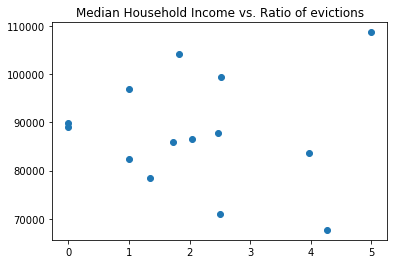

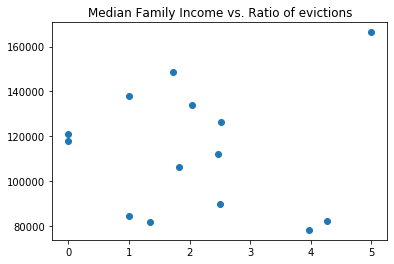

[0, 1.819672131147541, 1.35, 3.966666666666667, 2.5142857142857142, 2.0454545454545454, 4.2727272727272725, 1.0, 1.7222222222222223, 5.0, 2.473684210526316, 1.0, 2.5, 0] 0     121056.20
1     106249.75
2      81612.05
3      78124.88
4     126371.90
5     134062.14
6      82049.48
7     138042.96
8     148577.26
9     166421.96
10    111958.18
11     84335.07
12     89543.44
13    118033.74
Name: Median Family Income, dtype: float64


In [173]:
# eviction ratio vs. income
x = [0] + [freqs[x][0] / freqs[x][1] for x in freqs if freqs[x][1] != 0] + [0]
y = neighborhood_income['Median Household Income']
plt.scatter(x, y)
plt.title('Median Household Income vs. Ratio of evictions')
plt.show()

x = [0] + [freqs[x][0] / freqs[x][1] for x in freqs if freqs[x][1] != 0] + [0]
y = neighborhood_income['Median Family Income']
plt.scatter(x, y)
plt.title('Median Family Income vs. Ratio of evictions')
plt.show()

print(x, y)